## Task 2 - Classification/Regression (Use all features) - <span style="color:red; font-weight:bold;">This is a classificationd dataset</span>

Write a Python program to build a MLP classifier and evaluate your model’s performance. For this task, you should use the pre-processed and transformed dataset without feature selection from Task 3.1.

<span style="font-weight:bold;">Save your response (program and markdown) as task2.ipynb</span>

In [1]:
# when to use linear regression

# TRY GPU FOR RUNNING PROGRAMS

In [1]:
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt 
from functions.pre_processing import *
from functions.transformations import *
from functions.feature_selection import *
from functions.analysis import *
from functions.classifiers import *
from functions.evaluation import *
from sklearn.metrics import accuracy_score

-----
## Pre-Processing and Transformation

In [2]:
x_train, x_test, y_train, y_test = fetch_datasets()
x_train_norm, x_test_norm = normalise_min_max(x_train, x_test)
# x_train_norm, x_test_norm = normalise_std_scaler(x_train, x_test)

# x_train_norm, x_test_norm = normalise_robust_scaler(x_train, x_test)



---
## MLP Classifier Training

In [3]:
mlp_training_holdout = mlp_classifier(x_train, x_test, y_train, y_test, "holdout")
mlp_training_cv = mlp_classifier(x_train, x_test, y_train, y_test, "cv")
mlp_training_k_fold = mlp_classifier(x_train, x_test, y_train, y_test, "k_fold")
mlp_training_k_fold_strat = mlp_classifier(x_train, x_test, y_train, y_test, "k_fold_strat")

------ Holdout Validation ------
Training Accuracy: 0.9983950617283951
Testing Accuracy: 0.9287037037037037
------ Cross Validation ------
Mean Accuracy: 0.9320987654320987
------ K fold Validation ------
Mean Accuracy: 0.9314197530864197
Std Deviation: 0.0035829066323287578
------ Stratified K fold Validation ------
Mean Accuracy: 0.9314814814814815
Std Deviation: 0.005281296206470979


---
## Hyperparameter Optimisation [Create a table showing the split of responses]

Best configuration - hidden_layers=(100,), activation=tanh, solver=adam, alpha=0.05

Mean - 0.932037037037037

In [6]:
# Use nested CV here
# Confusion Matrix & Classification Report

# Make this a module?

# max_iters?
hidden_layers = [(50,50,50), (50,100,50), (100,)]
activations = ['tanh', 'relu']
solvers = ['sgd', 'adam']
alphas = [0.0001, 0.05]

outer_cv = KFold(n_splits=10, shuffle=True)

for layer in range(len(hidden_layers)):
     for activation in range(len(activations)):
          for solver in range(len(solvers)):
               for alpha in range(len(alphas)):
                    inner_scores = []
                    mlp_clf = MLPClassifier(hidden_layer_sizes=hidden_layers[layer], activation=activations[activation], solver=solvers[solver], alpha=alphas[alpha])

                    # Nested CV
                    for train_index, val_index in outer_cv.split(x_train):
                         X_train, X_val = x_train[train_index], x_train[val_index]
                         Y_train, Y_val = y_train[train_index], y_train[val_index]
                         mlp_clf.fit(X_train, Y_train)
                         training_score = mlp_clf.score(X_train, Y_train)
                         test_score = mlp_clf.score(X_val, Y_val)
                         inner_scores.append(test_score)
                    
                    mean_score = sum(inner_scores) / len(inner_scores)

                    print(f"------- With hidden_layers={hidden_layers[layer]}, activation={activations[activation]}, solver={solvers[solver]}, alpha={alphas[alpha]}")
                    print(f"Mean - {mean_score}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

------- With hidden_layers=(50, 50, 50), activation=tanh, solver=sgd, alpha=0.0001
Mean - 0.9292592592592592


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

------- With hidden_layers=(50, 50, 50), activation=tanh, solver=sgd, alpha=0.05
Mean - 0.9292592592592592
------- With hidden_layers=(50, 50, 50), activation=tanh, solver=adam, alpha=0.0001
Mean - 0.9270370370370371
------- With hidden_layers=(50, 50, 50), activation=tanh, solver=adam, alpha=0.05
Mean - 0.9270987654320988


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

------- With hidden_layers=(50, 50, 50), activation=relu, solver=sgd, alpha=0.0001
Mean - 0.9295061728395062


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

------- With hidden_layers=(50, 50, 50), activation=relu, solver=sgd, alpha=0.05
Mean - 0.9287654320987654
------- With hidden_layers=(50, 50, 50), activation=relu, solver=adam, alpha=0.0001
Mean - 0.9238888888888889
------- With hidden_layers=(50, 50, 50), activation=relu, solver=adam, alpha=0.05
Mean - 0.9248148148148149


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

------- With hidden_layers=(50, 100, 50), activation=tanh, solver=sgd, alpha=0.0001
Mean - 0.9303086419753086


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

------- With hidden_layers=(50, 100, 50), activation=tanh, solver=sgd, alpha=0.05
Mean - 0.9280864197530864
------- With hidden_layers=(50, 100, 50), activation=tanh, solver=adam, alpha=0.0001
Mean - 0.9289506172839506
------- With hidden_layers=(50, 100, 50), activation=tanh, solver=adam, alpha=0.05
Mean - 0.92820987654321


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

------- With hidden_layers=(50, 100, 50), activation=relu, solver=sgd, alpha=0.0001
Mean - 0.9292592592592592


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

------- With hidden_layers=(50, 100, 50), activation=relu, solver=sgd, alpha=0.05
Mean - 0.9295061728395062
------- With hidden_layers=(50, 100, 50), activation=relu, solver=adam, alpha=0.0001
Mean - 0.9251851851851851
------- With hidden_layers=(50, 100, 50), activation=relu, solver=adam, alpha=0.05
Mean - 0.9282716049382715


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

------- With hidden_layers=(100,), activation=tanh, solver=sgd, alpha=0.0001
Mean - 0.9274074074074073


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

------- With hidden_layers=(100,), activation=tanh, solver=sgd, alpha=0.05
Mean - 0.9260493827160493
------- With hidden_layers=(100,), activation=tanh, solver=adam, alpha=0.0001
Mean - 0.9311728395061728
------- With hidden_layers=(100,), activation=tanh, solver=adam, alpha=0.05
Mean - 0.9304938271604938


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

------- With hidden_layers=(100,), activation=relu, solver=sgd, alpha=0.0001
Mean - 0.9256790123456791


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

------- With hidden_layers=(100,), activation=relu, solver=sgd, alpha=0.05
Mean - 0.927962962962963
------- With hidden_layers=(100,), activation=relu, solver=adam, alpha=0.0001
Mean - 0.9285185185185185
------- With hidden_layers=(100,), activation=relu, solver=adam, alpha=0.05
Mean - 0.932037037037037


-----------------------------------------------------------------
## Evaluation
Show how each compares to a model with greater feature selection

#### Classification Report - <span style="color:red; font-weight:bold;">Fix class 1.0 and 6.0</span>
Why needed xyz 

In [4]:
# ---- Metric Evaluation (R2, RMSE)
# PROPER TRAINING AND TESTING PROTOCOLS
# precision-recall, ROC curve data, and DET curve data.

''' Classification Report - Model correctly predicted well for a few classes, but it could be because of the amount of predictions 
as the predictions was bad across the board'''
fetch_classification_report(mlp_training_holdout, x_test_norm, y_test)

# Plot a graph showing predicted vs actual values (show how it is the feature selection that is the issue)

----- Classification Report -----
              precision    recall  f1-score   support

         0.0       1.00      0.07      0.13       613
         1.0       0.23      1.00      0.37       605
         2.0       0.73      0.65      0.69       628
         3.0       0.83      0.35      0.49       499
         4.0       0.93      0.88      0.90       507
         5.0       1.00      0.05      0.10       409
         6.0       0.43      0.84      0.57       481
         7.0       0.95      0.81      0.87       583
         8.0       1.00      0.04      0.08       511
         9.0       1.00      0.00      0.00       564

    accuracy                           0.48      5400
   macro avg       0.81      0.47      0.42      5400
weighted avg       0.80      0.48      0.43      5400



#### Confusion Matrix
Why needed xyz 

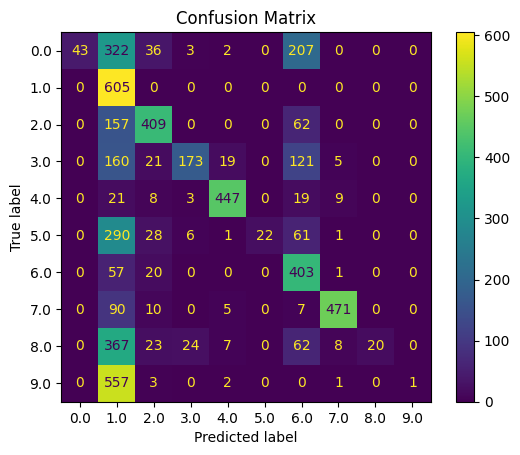

In [5]:
plot_confusion_matrix(mlp_training_holdout, x_test_norm, y_test)

#### Precision Recall, ROC, and DET Curve
Why needed xyz 

- ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.
- Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.
- ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets. [WE HAVE IMBALANCED DATASET]

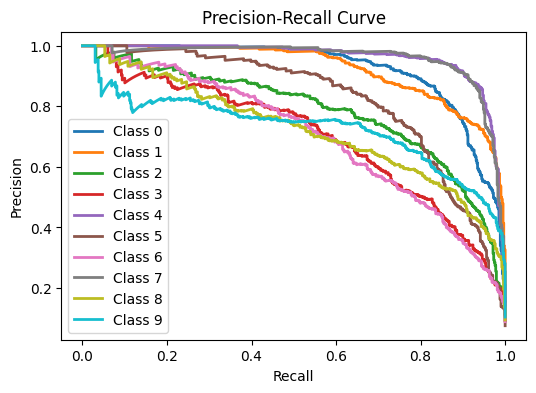

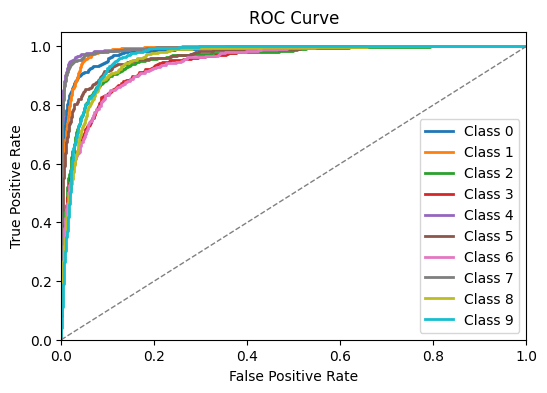

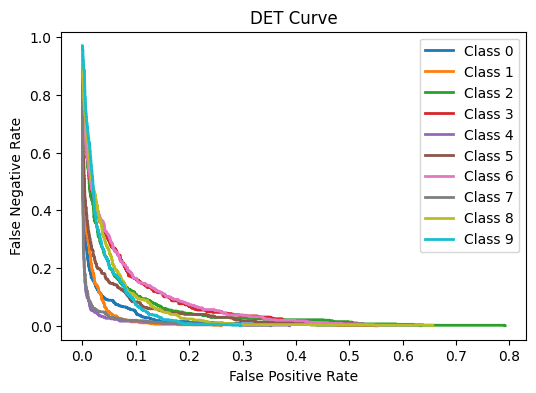

In [6]:
y_pred = mlp_training_holdout.predict_proba(x_test_norm)
plot_precision_recall_curve(y_test, y_pred)
plot_roc_curve(y_test, y_pred)
plot_det_curve(y_test, y_pred)

[3. 9. 9. ... 3. 4. 2.]
3.0
9.0
9.0
0.0
0.0
6.0
5.0
7.0
7.0
4.0
6.0
7.0
6.0
7.0
8.0
9.0
1.0
8.0
3.0
0.0
7.0
2.0
0.0
2.0
0.0
2.0
6.0
7.0
2.0
9.0
0.0
7.0
1.0
8.0
1.0
4.0
7.0
7.0
6.0
9.0
9.0
0.0
9.0
2.0
3.0
8.0
3.0
1.0
7.0
9.0
9.0
8.0
0.0
0.0
2.0
5.0
0.0
0.0
4.0
9.0
0.0
3.0
1.0
9.0
4.0
5.0
1.0
5.0
0.0
0.0
6.0
2.0
1.0
6.0
4.0
0.0
1.0
4.0
5.0
8.0
7.0
6.0
6.0
3.0
9.0
1.0
9.0
8.0
7.0
6.0
8.0
8.0
5.0
0.0
2.0
2.0
3.0
4.0
0.0
4.0
0.0
4.0
5.0
7.0
9.0
9.0
0.0
9.0
8.0
0.0
1.0
1.0
8.0
9.0
1.0
0.0
3.0
9.0
1.0
0.0
4.0
5.0
0.0
3.0
6.0
3.0
6.0
7.0
5.0
1.0
1.0
2.0
1.0
6.0
2.0
7.0
0.0
1.0
4.0
2.0
3.0
2.0
4.0
2.0
7.0
4.0
5.0
0.0
3.0
3.0
4.0
1.0
3.0
3.0
4.0
7.0
9.0
8.0
4.0
1.0
8.0
9.0
9.0
2.0
9.0
7.0
4.0
6.0
5.0
2.0
6.0
9.0
2.0
9.0
9.0
4.0
3.0
3.0
0.0
2.0
1.0
3.0
2.0
1.0
5.0
9.0
3.0
9.0
3.0
6.0
2.0
1.0
2.0
3.0
3.0
8.0
7.0
2.0
4.0
2.0
7.0
1.0
9.0
5.0
6.0
6.0
9.0
7.0
2.0
4.0
8.0
5.0
7.0
2.0
4.0
9.0
6.0
8.0
2.0
7.0
3.0
5.0
9.0
8.0
6.0
0.0
2.0
0.0
6.0
1.0
8.0
7.0
9.0
5.0
3.0
8.0
6.0
4.0
1.0
7.0
2.0
6.0
2.0
0.0


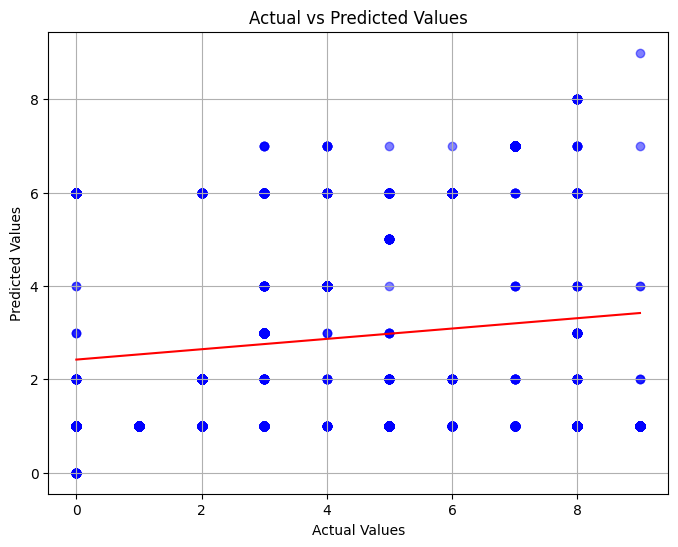

In [9]:
# Manually plot graph
y_pred = mlp_training_holdout.predict(x_test_norm)
print(y_test)
for i in y_test:
    print(i)
plot_predicted_vs_actual(y_test, y_pred)

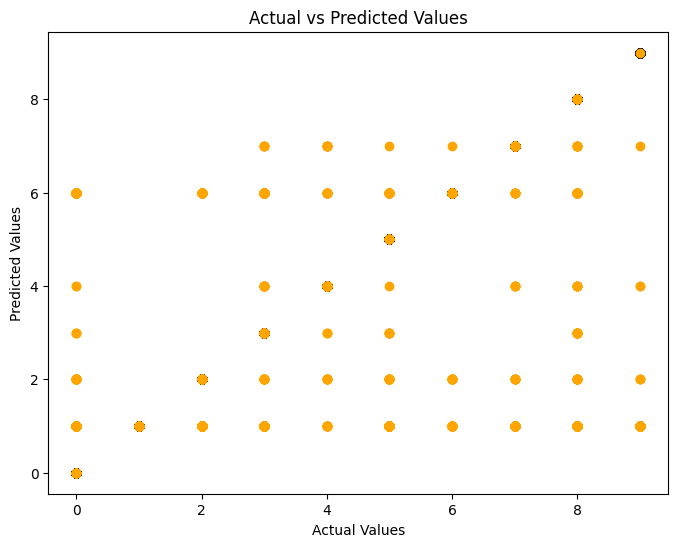

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test, color='blue', label='Actual')  
plt.scatter(y_test, y_pred, color='organge', label='Predicted') 
# plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)), color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()